In [5]:
import os
import sys
import random
import ast
from collections import Counter

import math
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from PIL import Image

import torch
from torch.nn import functional as F

from torchvision import transforms

import torch_geometric
from torch_geometric.data import HeteroData, download_url, extract_zip
from torch_geometric.nn import HeteroConv, SAGEConv, Linear, to_hetero
from torch_geometric.transforms import ToUndirected, AddSelfLoops

from transformers import AutoTokenizer, AutoModel, AutoImageProcessor, AutoModelForImageClassification, ViTImageProcessor, ViTModel

import kgbench as kg

In [6]:
DATASET_NAME = "dmg777k"

print(f"Loading dataset: {DATASET_NAME}...")
data = kg.load(DATASET_NAME)
print("Dataset loaded successfully.")

Loading dataset: dmg777k...
loaded data dmg777k (45.48s).
Dataset loaded successfully.


In [7]:
    print(f'{data.triples.shape[0]} triples')
    print(f'{data.num_relations} relations')
    print(f'{data.num_entities} nodes')
    print()

    literals = 0
    for datatype in data.datatypes():
        print(f'    {datatype}, {len(data.get_strings(datatype))} ')
        if datatype not in ['iri', 'blank_node']:
            literals += len(data.get_strings(datatype))

    print(f'{len(data.get_strings("iri")) + len(data.get_strings("blank_node"))} entities.')
    print(f'{literals} literals.')
    print()
    print(f'{data.num_classes} classes ')

777124 triples
60 relations
341270 nodes

    iri, 148127 
    none, 27886 
    @es, 1 
    @fy, 11 
    @nl, 397 
    @nl-nl, 33721 
    @pt, 1 
    @ru, 14 
    http://kgbench.info/dt#base64Image, 46061 
    http://www.opengis.net/ont/geosparql#wktLiteral, 20837 
    http://www.w3.org/2001/XMLSchema#anyURI, 55031 
    http://www.w3.org/2001/XMLSchema#boolean, 2 
    http://www.w3.org/2001/XMLSchema#gYear, 290 
    http://www.w3.org/2001/XMLSchema#nonNegativeInteger, 8396 
    http://www.w3.org/2001/XMLSchema#positiveInteger, 495 
148127 entities.
193143 literals.

5 classes 


In [8]:
# Make sure you have the correct reference to your data object
# Replace 'data' with your actual variable name if different
# For example: data = subset_kg or data = graph_data

def explore_classes(data):
    """Explore and display classes in the knowledge graph dataset"""
    print("Exploring classes in the dataset...")
    
    # Method 1: Check class indices in training data
    if hasattr(data, 'training') and len(data.training) > 0:
        class_indices = set([class_idx for _, class_idx in data.training])
        print(f"\nFound {len(class_indices)} unique classes in training data:")
        print(f"Class indices: {sorted(class_indices)}")
    
    # Method 2: Extract class information from literals and relations
    if hasattr(data, 'i2r') and hasattr(data, 'triples'):
        # Find relations related to classes or types
        class_predicates = []
        for r_idx, relation in enumerate(data.i2r):
            rel_lower = relation.lower()
            if any(term in rel_lower for term in ['class', 'category', 'type', 'monument']):
                class_predicates.append(r_idx)
        
        if class_predicates:
            print(f"\nFound {len(class_predicates)} potential class-related predicates:")
            for p_idx in class_predicates:
                print(f"  - {p_idx}: {data.i2r[p_idx]}")
            
            # Count class objects for each predicate
            for p_idx in class_predicates:
                print(f"\nClasses using predicate: {data.i2r[p_idx]}")
                
                # Collect objects of class predicate
                class_objects = {}
                for s, p, o in data.triples:
                    if p == p_idx:
                        if o not in class_objects:
                            class_objects[o] = 0
                        class_objects[o] += 1
                
                # Display top classes
                for o_idx, count in sorted(class_objects.items(), key=lambda x: x[1], reverse=True)[:10]:
                    if hasattr(data, 'i2n'):
                        # Use i2n for more detailed node info
                        node_info = data.i2n[o_idx]
                        print(f"  - {node_info}: {count} entities")
                    else:
                        # Fall back to i2e if available
                        if hasattr(data, 'i2e'):
                            print(f"  - {data.i2e[o_idx]}: {count} entities")
                        else:
                            print(f"  - Object index {o_idx}: {count} entities")
    
    # Method 3: Check nodes with different datatypes
    if hasattr(data, 'datatypes'):
        print("\nDatatype distribution in the dataset:")
        for dtype in data.datatypes():
            if hasattr(data, 'datatype_l2g') and hasattr(data, 'datatype_g2l'):
                local_indices = data.datatype_g2l(dtype)
                if local_indices:
                    print(f"  - {dtype}: {len(local_indices)} nodes")
            else:
                # Fallback if the conversion functions aren't available
                count = 0
                if hasattr(data, 'i2n'):
                    for node_info in data.i2n:
                        if node_info[1] == dtype:
                            count += 1
                print(f"  - {dtype}: {count} nodes")
    
    # Method 4: Use the training data to determine actual class distribution
    if hasattr(data, 'training') and len(data.training) > 0:
        from collections import Counter
        class_counts = Counter([class_idx for _, class_idx in data.training])
        
        print("\nClass distribution in training data:")
        for class_idx, count in sorted(class_counts.items()):
            print(f"Class {class_idx}: {count} instances")
        
        # If we have access to actual class names through some mapping
        # Try to find labels or names for these classes
        if hasattr(data, 'i2c'):
            print("\nClass names:")
            for class_idx in sorted(class_counts.keys()):
                print(f"Class {class_idx}: {data.i2c[class_idx]}")
        elif hasattr(data, 'class_names'):
            print("\nClass names:")
            for class_idx in sorted(class_counts.keys()):
                if class_idx < len(data.class_names):
                    print(f"Class {class_idx}: {data.class_names[class_idx]}")

# Call the function with your data object
explore_classes(data)

Exploring classes in the dataset...

Found 5 unique classes in training data:
Class indices: [0, 1, 2, 3, 4]

Found 3 potential class-related predicates:
  - 2: http://dbpedia.org/ontology/codeNationalMonument
  - 16: http://www.geonames.org/ontology#featureClass
  - 31: http://www.w3.org/1999/02/22-rdf-syntax-ns#type

Classes using predicate: http://dbpedia.org/ontology/codeNationalMonument
  - ('10000', 'http://www.w3.org/2001/XMLSchema#nonNegativeInteger'): 1 entities
  - ('10006', 'http://www.w3.org/2001/XMLSchema#nonNegativeInteger'): 1 entities
  - ('10007', 'http://www.w3.org/2001/XMLSchema#nonNegativeInteger'): 1 entities
  - ('10008', 'http://www.w3.org/2001/XMLSchema#nonNegativeInteger'): 1 entities
  - ('10011', 'http://www.w3.org/2001/XMLSchema#nonNegativeInteger'): 1 entities
  - ('10012', 'http://www.w3.org/2001/XMLSchema#nonNegativeInteger'): 1 entities
  - ('10014', 'http://www.w3.org/2001/XMLSchema#nonNegativeInteger'): 1 entities
  - ('10017', 'http://www.w3.org/2001/

Exploratory Data Analysis on dmg777k Dataset

(a) Types and corresponding Number of Entities (Nodes):
  - Land_Geografisch: 1
  - MultiSurface: 371
  - Geometry: 65,576
  - GeoFeature: 388
  - Gemeente_Geografisch: 387
  - Afbeelding: 60,996
  - Feature: 2,407
Total number of entities: 0
Total number of entities: 130126
Total number of entities: 148127
Total number of literals: 193143
Total number of nodes: 341270


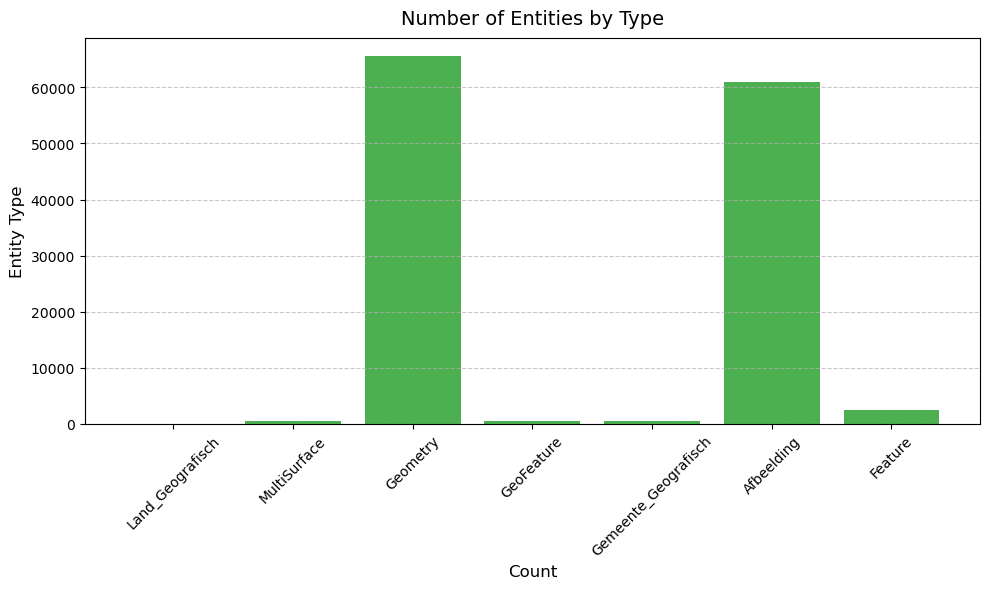


(b) Types and Number of Edges (Relations):
  - Total Number of Edges (Triples): 777,124
  - Number of Unique Relation Types: 60


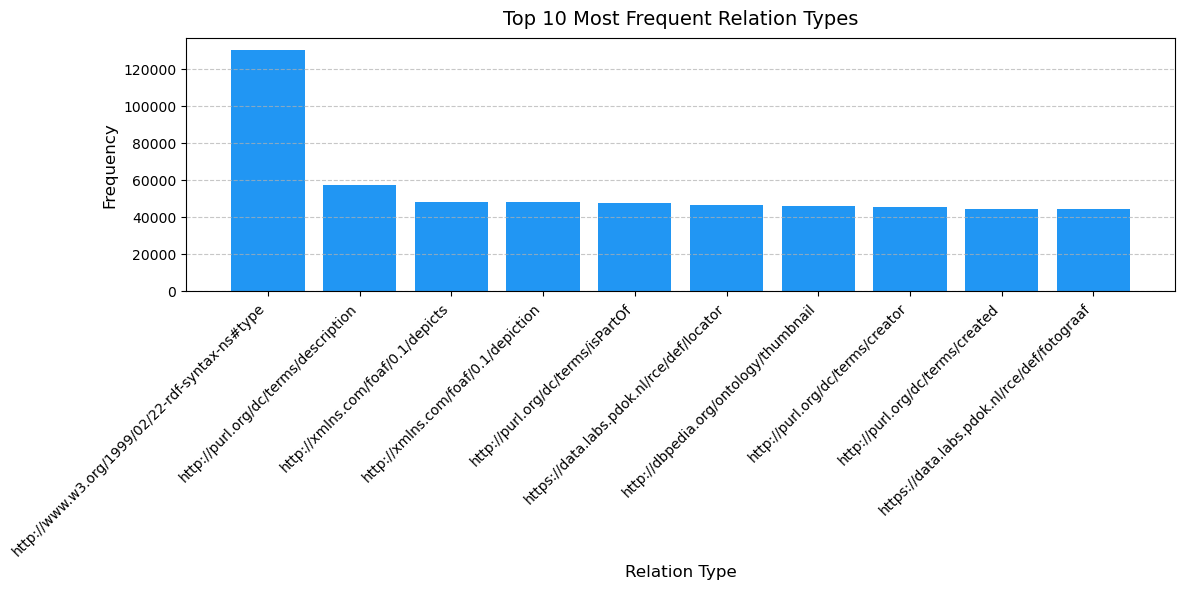


(c) Types of Information Present Per Node (Literals):
  Literal Datatypes and Their Counts:
    - none: 27,886
    - @es: 1
    - @fy: 11
    - @nl: 397
    - @nl-nl: 33,721
    - @pt: 1
    - @ru: 14
    - http://kgbench.info/dt#base64Image: 46,061
    - http://www.opengis.net/ont/geosparql#wktLiteral: 20,837
    - http://www.w3.org/2001/XMLSchema#anyURI: 55,031
    - http://www.w3.org/2001/XMLSchema#boolean: 2
    - http://www.w3.org/2001/XMLSchema#gYear: 290
    - http://www.w3.org/2001/XMLSchema#nonNegativeInteger: 8,396
    - http://www.w3.org/2001/XMLSchema#positiveInteger: 495
  - Total Literals: 193,143


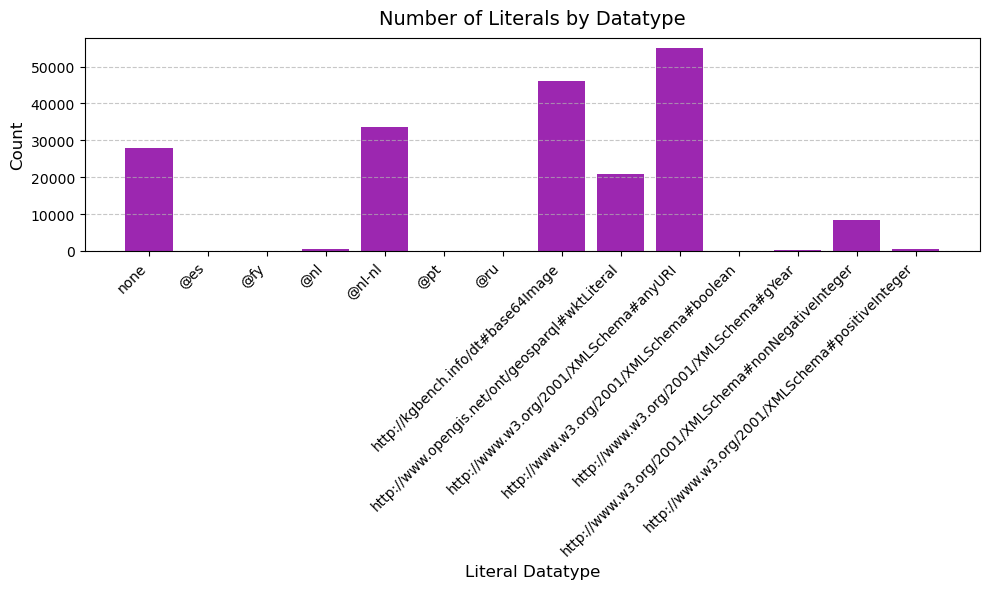


(d) Understanding the Triples Attribute:
  - Triples Shape: (777124, 3) (rows = edges, columns = [subject, relation, object])
  - Example Triple: [130685     28  54795] (s: ('http://bag.basisregistraties.overheid.nl/bag/id/geometry/0003549B7CE875B77925FFA6CC2C2861', 'iri'), r: http://www.opengis.net/ont/geosparql#asWKT, o: ('POLYGON ((4.667227191836703 51.81920171648348, 4.667236120685068 51.819203883584755, 4.6672263678506125 51.81920790458488, 4.667215533196375 51.81921064256385, 4.667204024085515 51.81921201912295, 4.667192305891625 51.8192119562197, 4.667180842410027 51.81921047467658, 4.6671700681438875 51.819207613114045, 4.667166621983456 51.81920634255311, 4.667156165455297 51.819200840285575, 4.667147349428573 51.81919433236882, 4.667140403217145 51.81918699099386, 4.667135780138812 51.819179493088576, 4.667129317016587 51.819177323131235, 4.667130389037754 51.81917558591724, 4.667152519231947 51.81913942566619, 4.667155115181994 51.81913944159352, 4.667171227731092 51.819123

In [9]:
print("=" * 50)
print("Exploratory Data Analysis on dmg777k Dataset")
print("=" * 50)

# --- (a) Plot the types and number of entities (nodes) ---
type_relations = [r for r in data.i2r if "type" in r.lower()]

entity_types = set()
for s, p, o in data.triples:
    if data.i2r[p] in type_relations:  
        entity_types.add(str(data.i2e[o]))  
        
literals = 0
for datatype in data.datatypes():
    if datatype not in ['iri', 'blank_node']:
        literals += len(data.get_strings(datatype))

sorted(entity_types)
entity_list = list(entity_types)
tuple_list = [ast.literal_eval(t) for t in entity_list]
entity_counts = {etype: 0 for etype in entity_types}

mapping = {
    'http://www.opengis.net/ont/geosparql#Geometry': 'Geometry',
    'https://data.labs.pdok.nl/rce/def/Afbeelding': 'Afbeelding',
    'https://data.pldn.nl/cbs/wijken-buurten/def/cbs#Land_Geografisch': 'Land_Geografisch',
    'http://www.opengis.net/ont/gml#MultiSurface': 'MultiSurface',
    'https://data.pldn.nl/cbs/wijken-buurten/def/cbs#Gemeente_Geografisch': 'Gemeente_Geografisch',
    'http://www.geonames.org/ontology#Feature': 'Feature',
    'http://www.opengis.net/ont/geosparql#Feature': 'GeoFeature',
}

for s, p, o in data.triples:
    if data.i2r[p] in type_relations:  
        entity_type = str(data.i2e[o])  
        if entity_type in entity_counts:
            entity_counts[entity_type] += 1

print("\n(a) Types and corresponding Number of Entities (Nodes):")
for type, _ in tuple_list:
    type_tuple = (type, 'iri') 
    print(f"  - {mapping[type]}: {entity_counts[str(type_tuple)]:,}")

entity_types_list = [mapping.get(type, type) for type, _ in tuple_list] 
counts = list(entity_counts.values()) 

print(f"Total number of entities: {len(data.get_strings('blank_node'))}")
print(f"Total number of entities: {sum(counts)}")
print(f"Total number of entities: {len(data.get_strings('iri')) + len(data.get_strings('blank_node'))}")
print(f"Total number of literals: {literals}")
print(f"Total number of nodes: {data.num_entities}")

plt.figure(figsize=(10, 6))
plt.bar(entity_types_list, counts, color='#4CAF50')  
plt.title('Number of Entities by Type', fontsize=14, pad=10)
plt.ylabel('Entity Type', fontsize=12)  
plt.xlabel('Count', fontsize=12) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()


# --- (b) Plot the types and number of edges ---
print("\n(b) Types and Number of Edges (Relations):")
relation_counter = Counter(data.triples[:, 1])  # Relation is the second element in triples
total_edges = data.triples.shape[0]
print(f"  - Total Number of Edges (Triples): {total_edges:,}")
print(f"  - Number of Unique Relation Types: {data.num_relations}")

# Plot the top 10 most frequent relations
top_n = 10
most_common_relations = relation_counter.most_common(top_n)
relations, counts = zip(*most_common_relations)
relation_names = [data.i2r[rel] for rel in relations]

plt.figure(figsize=(12, 6))
plt.bar(relation_names, counts, color='#2196F3')
plt.title(f'Top {top_n} Most Frequent Relation Types', fontsize=14, pad=10)
plt.xlabel('Relation Type', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- (c) See what type of information is present per node ---
print("\n(c) Types of Information Present Per Node (Literals):")
datatypes = data.datatypes()
literal_datatypes = [dt for dt in datatypes if dt not in ['iri', 'blank_node']]
print("  Literal Datatypes and Their Counts:")
for dt in literal_datatypes:
    count = len(data.get_strings(dt))
    print(f"    - {dt}: {count:,}")
total_literals = sum(len(data.get_strings(dt)) for dt in literal_datatypes)
print(f"  - Total Literals: {total_literals:,}")

# Plot literal datatypes
plt.figure(figsize=(10, 6))
literal_counts = [len(data.get_strings(dt)) for dt in literal_datatypes]
plt.bar(literal_datatypes, literal_counts, color='#9C27B0')
plt.title('Number of Literals by Datatype', fontsize=14, pad=10)
plt.xlabel('Literal Datatype', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- (d) The triples attribute defines your graphs ---
print("\n(d) Understanding the Triples Attribute:")
print(f"  - Triples Shape: {data.triples.shape} (rows = edges, columns = [subject, relation, object])")
print(f"  - Example Triple: {data.triples[0]} (s: {data.i2e[data.triples[0,0]]}, "
      f"r: {data.i2r[data.triples[0,1]]}, o: {data.i2e[data.triples[0,2]]})")
print("  - Explanation: The triples are a numpy array where each row represents an edge in the graph.")
print("    - Subject and Object are entity indices, Relation is a relation type index.")
print("    - This defines the graph structure for GNNs, with nodes as entities and edges as relations.")

# --- (e) The e2i / i2e fields might also help ---
print("\n(e) Exploring e2i and i2e Fields:")
print(f"  - i2e Example (index 0): {data.i2e[0]} (maps entity index to string)")
print(f"  - i2r Example (index 0): {data.i2r[0]} (maps relation index to string)")
print("  - Explanation: e2i maps entity strings to indices, i2e maps indices back to strings.")
print("    - Similarly, r2i and i2r handle relations. Useful for interpreting the graph.")

# --- (f) How to use this to train a Graph Neural Network (GNN) ---
# print("\n(f) Using dmg777k to Train a Graph Neural Network (GNN):")
# print("  - Graph Structure:")
# print("    - Use data.triples to build the adjacency list/matrix (subjects and objects as nodes, relations as edges).")
# print("  - Node Labels:")
# print(f"    - Training: {data.training.shape[0]:,} instances (node indices and class labels).")
# print(f"    - Validation: {data.withheld.shape[0]:,} instances.")
# data_final = kg.load('dmg777k', torch=False, prune_dist=None, final=True)
# print(f"    - Test: {data_final.withheld.shape[0]:,} instances.")
# print("  - Node Features:")
# print("    - Use literals (e.g., images via data.get_images(), text) as multimodal features.")
# print("    - Process images with a CNN, text with embeddings, etc., and attach to corresponding nodes.")
# print("  - Model:")
# print("    - Use a GNN (e.g., R-GCN) to leverage relational structure.")
# print("    - Combine with a multimodal feature extractor for literals.")
# print("  - Task:")
# print("    - Node classification, predicting class labels for nodes based on structure and features.")

# print("=" * 50)
# print("EDA Complete")
# print("=" * 50)

In [10]:
import random
import networkx as nx
import numpy as np

def create_fair_kg_subset(data, sample_percentage=0.15, min_entities_per_type=50):
    """
    Creates a fair and representative subset of the knowledge graph
    that preserves entity type distributions and relation structure.
    """
    # 1. Identify entity types and their instances
    entity_by_type = {}
    type_relations = [r for r in range(len(data.i2r)) if "type" in data.i2r[r].lower()]
    
    for s, p, o in data.triples:
        if p in type_relations:
            entity_type = str(data.i2e[o])
            if entity_type not in entity_by_type:
                entity_by_type[entity_type] = set()
            entity_by_type[entity_type].add(s)
    
    # 2. Sample entities proportionally by type
    sampled_entities = set()
    for entity_type, entities in entity_by_type.items():
        # Calculate proportional sample size, but ensure minimum representation
        sample_size = max(
            min_entities_per_type,
            int(len(entities) * sample_percentage)
        )
        # Adjust if sample size exceeds available entities
        sample_size = min(sample_size, len(entities))
        sampled_entities.update(random.sample(list(entities), sample_size))
    
    # 3. Extend with 1-hop neighborhood to ensure relation preservation
    neighborhood = set(sampled_entities)
    for s, p, o in data.triples:
        if s in sampled_entities and data.i2e[o][1] == 'iri':  # Only add entity objects, not literals
            neighborhood.add(o)
        if o in sampled_entities and data.i2e[s][1] == 'iri':
            neighborhood.add(s)
    
    # 4. Extract relevant literals for all entities in the neighborhood
    # This ensures we have the descriptive attributes for our entities
    entities_with_literals = set(neighborhood)
    for s, p, o in data.triples:
        if s in neighborhood and data.i2e[o][1] != 'iri' and data.i2e[o][1] != 'blank_node':
            entities_with_literals.add(o)
    
    # 5. Create the subset of triples
    subset_triples = []
    for triple in data.triples:
        s, p, o = triple
        # Include triple if:
        # - Both subject and object are in our neighborhood, OR
        # - Subject is in neighborhood and object is a literal, OR
        # - Object is in neighborhood and appropriate to include
        if (s in neighborhood and o in neighborhood) or \
           (s in neighborhood and data.i2e[o][1] not in ['iri', 'blank_node']) or \
           (o in neighborhood and s in sampled_entities):
            subset_triples.append(triple)
    
    # 6. Check connectivity and add bridging triples if needed
    if len(subset_triples) > 0:
        G = nx.Graph()
        for s, _, o in subset_triples:
            if data.i2e[s][1] == 'iri' and data.i2e[o][1] == 'iri':  # Only consider entity-entity relations
                G.add_edge(int(s), int(o))
        
        # Find connected components
        components = list(nx.connected_components(G))
        
        # If multiple disconnected components exist and they're significant in size
        if len(components) > 1 and max(len(c) for c in components) < len(G.nodes) * 0.9:
            # Connect the components by finding shortest paths in original graph
            full_G = nx.Graph()
            for s, _, o in data.triples:
                if data.i2e[s][1] == 'iri' and data.i2e[o][1] == 'iri':
                    full_G.add_edge(int(s), int(o))
            
            # Connect largest components
            sorted_components = sorted(components, key=len, reverse=True)
            for i in range(min(5, len(sorted_components) - 1)):  # Connect top 5 components
                source = random.choice(list(sorted_components[0]))  # From largest component
                target = random.choice(list(sorted_components[i + 1]))  # To other component
                
                try:
                    path = nx.shortest_path(full_G, source, target)
                    # Add all edges in path to our subset
                    for j in range(len(path) - 1):
                        # Find corresponding triples and add them
                        for triple in data.triples:
                            if (triple[0] == path[j] and triple[2] == path[j+1]) or \
                               (triple[0] == path[j+1] and triple[2] == path[j]):
                                subset_triples.append(triple)
                except nx.NetworkXNoPath:
                    continue
    
    # 7. Ensure training/validation instances are included proportionally
    if hasattr(data, 'training') and len(data.training) > 0:
        training_entities = set(data.training[:, 0])
        training_in_subset = training_entities.intersection(neighborhood)
        
        # If too few training entities included, add more
        if len(training_in_subset) < len(training_entities) * sample_percentage * 0.8:
            additional_needed = int(len(training_entities) * sample_percentage) - len(training_in_subset)
            if additional_needed > 0:
                candidates = list(training_entities - training_in_subset)
                additional = random.sample(candidates, min(additional_needed, len(candidates)))
                
                # Add these entities and their immediate context
                for entity in additional:
                    for triple in data.triples:
                        if triple[0] == entity or triple[2] == entity:
                            subset_triples.append(triple)
    
    return np.array(subset_triples)


In [11]:


# 2. Call the function to create your subset
subset_percentage = 0.15  # Adjust as needed (15% of original data)
min_per_type = 50  # Minimum entities to keep per type

subset_triples = create_fair_kg_subset(data, 
                                       sample_percentage=subset_percentage,
                                       min_entities_per_type=min_per_type)

# 3. Create a new dataset object from your subset (if needed)
# This depends on how your dataset is structured, but here's a generic approach
class SubsetKG:
    def __init__(self, original_data, subset_triples):
        # Copy the basic elements from the original data
        self.i2r = original_data.i2r
        self.i2e = original_data.i2e
        self.triples = subset_triples
        
        # Extract entities and relations in the subset
        self.subset_entities = set()
        self.subset_relations = set()
        
        for s, p, o in self.triples:
            self.subset_entities.add(s)
            self.subset_relations.add(p)
            self.subset_entities.add(o)
            
        self.num_entities = len(self.subset_entities)
        self.num_relations = len(self.subset_relations)
        
        # Filter training and validation data if available
        if hasattr(original_data, 'training'):
            # Keep only training instances for entities in our subset
            self.training = np.array([row for row in original_data.training 
                                     if row[0] in self.subset_entities])
        
        if hasattr(original_data, 'withheld'):
            # Keep only validation instances for entities in our subset
            self.withheld = np.array([row for row in original_data.withheld 
                                     if row[0] in self.subset_entities])
    
    # Add methods to access literals, similar to the original data object
    def datatypes(self):
        return data.datatypes()
    
    def get_strings(self, datatype):
        # Return only strings for entities in our subset
        original_strings = data.get_strings(datatype)
        return {k: v for k, v in original_strings.items() if k in self.subset_entities}
    
    # Add other necessary methods based on your needs

# Create the subset knowledge graph object
subset_kg = SubsetKG(data, subset_triples)

# 4. Verify the subset
print(f"Original KG: {data.triples.shape[0]:,} triples, {data.num_entities:,} entities")
print(f"Subset KG: {subset_kg.triples.shape[0]:,} triples, {subset_kg.num_entities:,} entities")
print(f"Reduction ratio: {subset_kg.triples.shape[0] / data.triples.shape[0]:.2%}")

# 5. Analyze entity type distribution in subset
type_relations = [r for r in range(len(data.i2r)) if "type" in data.i2r[r].lower()]
entity_types_orig = {}
entity_types_subset = {}

# Count original distribution
for s, p, o in data.triples:
    if p in type_relations:
        entity_type = str(data.i2e[o])
        if entity_type not in entity_types_orig:
            entity_types_orig[entity_type] = 0
        entity_types_orig[entity_type] += 1

# Count subset distribution
for s, p, o in subset_kg.triples:
    if p in type_relations:
        entity_type = str(data.i2e[o])
        if entity_type not in entity_types_subset:
            entity_types_subset[entity_type] = 0
        entity_types_subset[entity_type] += 1

# Print distribution comparison
print("\nEntity Type Distribution Comparison (Original vs Subset):")
for entity_type in entity_types_orig:
    orig_count = entity_types_orig.get(entity_type, 0)
    subset_count = entity_types_subset.get(entity_type, 0)
    print(f"  {entity_type}: {orig_count:,} → {subset_count:,} ({subset_count/orig_count:.2%})")

Original KG: 777,124 triples, 341,270 entities
Subset KG: 171,200 triples, 88,986 entities
Reduction ratio: 22.03%

Entity Type Distribution Comparison (Original vs Subset):
  ('http://www.opengis.net/ont/geosparql#Geometry', 'iri'): 65,576 → 10,129 (15.45%)
  ('http://www.geonames.org/ontology#Feature', 'iri'): 2,407 → 561 (23.31%)
  ('http://www.opengis.net/ont/geosparql#Feature', 'iri'): 388 → 388 (100.00%)
  ('https://data.pldn.nl/cbs/wijken-buurten/def/cbs#Gemeente_Geografisch', 'iri'): 387 → 387 (100.00%)
  ('https://data.labs.pdok.nl/rce/def/Afbeelding', 'iri'): 60,996 → 9,149 (15.00%)
  ('http://www.opengis.net/ont/gml#MultiSurface', 'iri'): 371 → 174 (46.90%)
  ('https://data.pldn.nl/cbs/wijken-buurten/def/cbs#Land_Geografisch', 'iri'): 1 → 1 (100.00%)


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv
from torchvision import models
from transformers import CLIPModel, CLIPProcessor
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

In [13]:
def extract_text_features(text_data, max_features=1000):
    """Extract Bag-of-Words features from text nodes"""
    vectorizer = CountVectorizer(max_features=max_features)
    bow_features = vectorizer.fit_transform(text_data)
    return bow_features.toarray(), vectorizer

In [14]:
class VisualFeatureExtractor:
    def __init__(self, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        self.model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
        self.processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        
    def extract_features(self, images):
        """Extract visual features using CLIP"""
        with torch.no_grad():
            inputs = self.processor(images=images, return_tensors="pt", padding=True).to(self.device)
            image_features = self.model.get_image_features(**inputs)
            # Normalize features
            image_features = F.normalize(image_features, p=2, dim=1)
        return image_features.cpu().numpy()

In [15]:
def create_node_features(data):
    """Combine features for all nodes in the graph"""
    node_features = {}
    
    # Process text nodes
    text_nodes = [node for node in data.nodes if data.get_node_type(node) == 'text']
    text_data = [data.get_node_text(node) for node in text_nodes]
    text_features, _ = extract_text_features(text_data)
    
    # Process image nodes
    image_nodes = [node for node in data.nodes if data.get_node_type(node) == 'image']
    image_data = [data.get_node_image(node) for node in image_nodes]
    visual_extractor = VisualFeatureExtractor()
    image_features = visual_extractor.extract_features(image_data)
    
    # Create feature dict for all nodes
    for i, node in enumerate(text_nodes):
        node_features[node] = text_features[i]
    
    for i, node in enumerate(image_nodes):
        node_features[node] = image_features[i]
        
    # Handle other node types with appropriate feature extraction
    # ...
    
    # Convert to tensor with consistent dimensions
    # Pad or project features to ensure consistent dimensions
    feature_dim = 512  # Common dimension for all features
    node_feature_matrix = torch.zeros((len(data.nodes), feature_dim))
    
    for i, node in enumerate(data.nodes):
        if node in node_features:
            # Project to common dimension if needed
            feat = torch.tensor(node_features[node], dtype=torch.float)
            if feat.shape[0] != feature_dim:
                feat = torch.nn.functional.pad(feat, (0, feature_dim - feat.shape[0])) if feat.shape[0] < feature_dim else feat[:feature_dim]
            node_feature_matrix[i] = feat
    
    return node_feature_matrix

In [16]:
from torch_geometric.data import Data

def build_graph_data(data, node_features):
    """Convert knowledge graph to PyTorch Geometric format"""
    # Create edge index and edge types
    edge_index = []
    edge_type = []
    
    # Extract edges from the knowledge graph
    for s, p, o in data.triples:
        # Convert to node indices
        source_idx = data.node_to_idx[s]
        target_idx = data.node_to_idx[o]
        relation_type = data.relation_to_idx[p]
        
        edge_index.append([source_idx, target_idx])
        edge_type.append(relation_type)
    
    # Convert to PyTorch tensors
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_type = torch.tensor(edge_type, dtype=torch.long)
    
    # Create PyG data object
    graph_data = Data(
        x=node_features,
        edge_index=edge_index,
        edge_type=edge_type,
        num_relations=len(data.relations),
        y=torch.tensor(data.labels, dtype=torch.long)
    )
    
    # Create train/val/test masks
    if hasattr(data, 'train_mask'):
        graph_data.train_mask = torch.tensor(data.train_mask, dtype=torch.bool)
    if hasattr(data, 'val_mask'):
        graph_data.val_mask = torch.tensor(data.val_mask, dtype=torch.bool)
    if hasattr(data, 'test_mask'):
        graph_data.test_mask = torch.tensor(data.test_mask, dtype=torch.bool)
    
    return graph_data

In [17]:
class RGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_relations, num_bases=8, dropout=0.5):
        super(RGCN, self).__init__()
        
        self.conv1 = RGCNConv(in_channels, hidden_channels, num_relations, num_bases=num_bases)
        self.conv2 = RGCNConv(hidden_channels, hidden_channels, num_relations, num_bases=num_bases)
        self.linear = nn.Linear(hidden_channels, out_channels)
        self.dropout = dropout
        
    def forward(self, x, edge_index, edge_type):
        x = self.conv1(x, edge_index, edge_type)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv2(x, edge_index, edge_type)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.linear(x)
        
        return F.log_softmax(x, dim=1)

In [18]:
def train_eval_model(model, data, epochs=200, lr=0.01):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    data = data.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    
    best_val_acc = 0
    best_model = None
    
    for epoch in range(1, epochs + 1):
        # Training
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_type)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        
        # Evaluation
        model.eval()
        with torch.no_grad():
            pred = out.argmax(dim=1)
            
            # Training accuracy
            train_correct = pred[data.train_mask] == data.y[data.train_mask]
            train_acc = int(train_correct.sum()) / int(data.train_mask.sum())
            
            # Validation accuracy
            val_correct = pred[data.val_mask] == data.y[data.val_mask]
            val_acc = int(val_correct.sum()) / int(data.val_mask.sum())
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model = model.state_dict().copy()
            
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
    
    # Load best model for final evaluation
    model.load_state_dict(best_model)
    model.eval()
    
    with torch.no_grad():
        out = model(data.x, data.edge_index, data.edge_type)
        pred = out.argmax(dim=1)
        test_correct = pred[data.test_mask] == data.y[data.test_mask]
        test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    
    print(f'Final Test Accuracy: {test_acc:.4f}')
    return model

In [19]:
def node_classification_pipeline(data_subset):
    # 1. Extract features for nodes
    node_features = create_node_features(data_subset)
    
    # 2. Build PyG graph data
    graph_data = build_graph_data(data_subset, node_features)
    
    # 3. Create and train model
    model = RGCN(
        in_channels=node_features.shape[1],
        hidden_channels=128,
        out_channels=data_subset.num_classes,
        num_relations=data_subset.num_relations,
        dropout=0.5
    )
    
    # 4. Train and evaluate
    trained_model = train_eval_model(model, graph_data)
    
    return trained_model, graph_data

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch_geometric.nn import RGCNConv
from torch_geometric.data import Data
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import random
from collections import defaultdict

# Fix random seed for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

#########################
# STEP 1: PREPARE DATA  #
#########################

def prepare_knowledge_graph(subset_kg):
    """
    Convert knowledge graph subset to format usable by PyTorch Geometric
    """
    print("Preparing knowledge graph data...")
    
    # 1. Get unique entities/nodes and relations
    entity_set = set()
    relation_set = set()
    
    for s, p, o in subset_kg.triples:
        entity_set.add(s)
        relation_set.add(p)
        entity_set.add(o)
    
    # 2. Create mappings
    entity_to_idx = {entity: idx for idx, entity in enumerate(entity_set)}
    relation_to_idx = {rel: idx for idx, rel in enumerate(relation_set)}
    
    # 3. Create edge index and edge type tensors
    edge_index = []
    edge_type = []
    
    for s, p, o in subset_kg.triples:
        # Skip self-loops and only include entity-entity relations
        # (assuming literals have a different data type indicator in i2e)
        if s != o and subset_kg.i2e[o][1] == 'iri':  
            edge_index.append([entity_to_idx[s], entity_to_idx[o]])
            edge_type.append(relation_to_idx[p])
    
    if len(edge_index) == 0:
        raise ValueError("No valid edges found in the graph! Check your subset criteria.")
        
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_type = torch.tensor(edge_type, dtype=torch.long)
    
    print(f"Created graph with {len(entity_set)} nodes and {len(edge_index[0])} edges")
    
    # 4. Create features for each node
    feature_dim = 128  # Set your desired feature dimension
    x = torch.zeros((len(entity_set), feature_dim))
    
    # For each entity, extract features from associated literals
    print("Extracting node features...")
    
    # Find properties/relations that point to literals
    literal_properties = defaultdict(list)
    for s, p, o in subset_kg.triples:
        if subset_kg.i2e[o][1] != 'iri' and subset_kg.i2e[o][1] != 'blank_node':
            literal_properties[p].append((s, o))
    
    # Get text features (combine all text literals associated with each entity)
    entity_texts = defaultdict(str)
    for p, pairs in literal_properties.items():
        # Check if it points to text-like literals
        for s, o in pairs:
            literal_type = subset_kg.i2e[o][1]
            if literal_type in ['string', 'langString']:
                # Add the literal value to entity's text
                entity_texts[s] += " " + str(subset_kg.i2e[o][0])
    
    # Apply Bag-of-Words on text
    if entity_texts:
        entities = list(entity_texts.keys())
        texts = [entity_texts[e] for e in entities]
        
        vectorizer = CountVectorizer(max_features=min(100, len(texts)))
        try:
            bow_features = vectorizer.fit_transform(texts).toarray()
            
            # Normalize bow_features
            scaler = StandardScaler()
            bow_features = scaler.fit_transform(bow_features)
            
            # Pad or truncate to feature_dim
            padded_features = np.zeros((bow_features.shape[0], feature_dim))
            for i in range(bow_features.shape[0]):
                feat_len = min(bow_features.shape[1], feature_dim)
                padded_features[i, :feat_len] = bow_features[i, :feat_len]
            
            # Assign features to corresponding nodes
            for i, entity in enumerate(entities):
                idx = entity_to_idx[entity]
                x[idx] = torch.tensor(padded_features[i], dtype=torch.float)
        except:
            print("Warning: Failed to extract BoW features. Using random features instead.")
    
    # For entities with no features, add some calculated features
    degree_in = defaultdict(int)
    degree_out = defaultdict(int)
    
    for s, _, o in subset_kg.triples:
        if s in entity_to_idx and o in entity_to_idx:
            degree_out[s] += 1
            degree_in[o] += 1
    
    print("Adding structural features for nodes with no text...")
    # Entities with no features get structural properties
    zero_rows = (x.sum(dim=1) == 0).nonzero(as_tuple=True)[0]
    for idx in zero_rows:
        entity = list(entity_to_idx.keys())[list(entity_to_idx.values()).index(idx.item())]
        x[idx, 0] = degree_in[entity] / max(1, max(degree_in.values()))
        x[idx, 1] = degree_out[entity] / max(1, max(degree_out.values()))
        
        # Random features for the rest of the dimensions
        x[idx, 2:] = torch.rand(feature_dim - 2) * 0.1
    
    # 5. Create labels for training (using entity types)
    # Find type relations
    type_relations = [r for r in range(len(subset_kg.i2r)) if "type" in subset_kg.i2r[r].lower()]
    
    entity_types = {}
    for s, p, o in subset_kg.triples:
        if p in type_relations and s in entity_to_idx:
            entity_types[s] = o
    
    # Map types to indices
    unique_types = list(set(entity_types.values()))
    type_to_idx = {t: i for i, t in enumerate(unique_types)}
    
    # Create labels tensor with a default class for entities without a type
    num_classes = len(unique_types) + 1  # +1 for entities without a type
    y = torch.full((len(entity_set),), num_classes - 1, dtype=torch.long)
    
    for entity, type_val in entity_types.items():
        idx = entity_to_idx[entity]
        y[idx] = type_to_idx[type_val]
    
    print(f"Created {num_classes} classes for node classification")
    
    # 6. Create masks for training, validation, and testing
    indices = list(range(len(entity_set)))
    random.shuffle(indices)
    
    train_size = int(0.7 * len(indices))
    val_size = int(0.15 * len(indices))
    
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]
    
    train_mask = torch.zeros(len(entity_set), dtype=torch.bool)
    val_mask = torch.zeros(len(entity_set), dtype=torch.bool)
    test_mask = torch.zeros(len(entity_set), dtype=torch.bool)
    
    train_mask[train_indices] = True
    val_mask[val_indices] = True
    test_mask[test_indices] = True
    
    # 7. Create PyG Data object
    data = Data(
        x=x,
        edge_index=edge_index, 
        edge_type=edge_type,
        y=y,
        train_mask=train_mask,
        val_mask=val_mask, 
        test_mask=test_mask,
        num_nodes=len(entity_set),
        num_relations=len(relation_set)
    )
    
    return data, entity_to_idx, relation_to_idx, num_classes

####################
# STEP 2: MODEL    #
####################

class RGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_relations, num_bases=8, dropout=0.5):
        super(RGCN, self).__init__()
        
        self.conv1 = RGCNConv(in_channels, hidden_channels, num_relations, num_bases=num_bases)
        self.conv2 = RGCNConv(hidden_channels, hidden_channels, num_relations, num_bases=num_bases)
        self.linear = nn.Linear(hidden_channels, out_channels)
        self.dropout = dropout
        
    def forward(self, x, edge_index, edge_type):
        x = self.conv1(x, edge_index, edge_type)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv2(x, edge_index, edge_type)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.linear(x)
        
        return F.log_softmax(x, dim=1)

########################
# STEP 3: TRAINING     #
########################

def train_model(data, num_classes, epochs=100, lr=0.01):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create model
    model = RGCN(
        in_channels=data.x.shape[1],
        hidden_channels=64,
        out_channels=num_classes,
        num_relations=data.num_relations,
        num_bases=min(8, data.num_relations),
        dropout=0.2
    )
    
    model = model.to(device)
    data = data.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    
    # For tracking metrics
    train_accs = []
    val_accs = []
    losses = []
    best_val_acc = 0
    best_model = None
    
    print("\nStarting training...")
    for epoch in range(1, epochs + 1):
        # Training
        model.train()
        optimizer.zero_grad()
        
        out = model(data.x, data.edge_index, data.edge_type)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        # Evaluation
        model.eval()
        with torch.no_grad():
            pred = out.argmax(dim=1)
            
            # Training accuracy
            train_correct = pred[data.train_mask] == data.y[data.train_mask]
            train_acc = float(train_correct.sum()) / max(1, int(data.train_mask.sum()))
            train_accs.append(train_acc)
            
            # Validation accuracy
            val_correct = pred[data.val_mask] == data.y[data.val_mask]
            val_acc = float(val_correct.sum()) / max(1, int(data.val_mask.sum()))
            val_accs.append(val_acc)
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model = {key: value.cpu() for key, value in model.state_dict().items()}
        
        if epoch % 10 == 0 or epoch == 1:
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
    
    # Load best model for final evaluation
    model.load_state_dict(best_model)
    model.eval()
    
    # Final test performance
    with torch.no_grad():
        out = model(data.x, data.edge_index, data.edge_type)
        pred = out.argmax(dim=1)
        test_correct = pred[data.test_mask] == data.y[data.test_mask]
        test_acc = float(test_correct.sum()) / max(1, int(data.test_mask.sum()))
    
    print(f'\nFinal results:')
    print(f'Best validation accuracy: {best_val_acc:.4f}')
    print(f'Test accuracy: {test_acc:.4f}')
    
    # Plot training curves
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train')
    plt.plot(val_accs, label='Validation')
    plt.axhline(y=test_acc, color='r', linestyle='--', label=f'Test ({test_acc:.4f})')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return model, test_acc

###############################
# STEP 4: RUNNING EVERYTHING  #
###############################

# After training completes:
def run_gnn_pipeline(subset_kg):
    """
    Complete pipeline to run GNN node classification on a knowledge graph subset
    """
    # 1. Prepare data
    try:
        data, entity_to_idx, relation_to_idx, num_classes = prepare_knowledge_graph(subset_kg)
        
        # 2. Train model
        model, test_acc = train_model(data, num_classes, epochs=100)
        
        print("\nSuccess! Model trained with test accuracy:", test_acc)
        
        # 3. Evaluate by class
        predictions, class_report = evaluate_by_class(model, data)
        
        return model, data, entity_to_idx, relation_to_idx
        
    except Exception as e:
        print(f"Error during pipeline execution: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None, None, None

Preparing knowledge graph data...
Created graph with 19135 nodes and 8502 edges
Extracting node features...
Adding structural features for nodes with no text...
Created 7 classes for node classification
Using device: cuda

Starting training...
Epoch: 001, Loss: 1.8755, Train Acc: 0.7530, Val Acc: 0.7704
Epoch: 010, Loss: 0.5000, Train Acc: 0.8906, Val Acc: 0.8969
Epoch: 020, Loss: 0.3291, Train Acc: 0.9284, Val Acc: 0.9324
Epoch: 030, Loss: 0.3224, Train Acc: 0.9291, Val Acc: 0.9338
Epoch: 040, Loss: 0.3165, Train Acc: 0.9300, Val Acc: 0.9352
Epoch: 050, Loss: 0.3117, Train Acc: 0.9305, Val Acc: 0.9362
Epoch: 060, Loss: 0.3097, Train Acc: 0.9305, Val Acc: 0.9362
Epoch: 070, Loss: 0.3077, Train Acc: 0.9306, Val Acc: 0.9366
Epoch: 080, Loss: 0.3035, Train Acc: 0.9305, Val Acc: 0.9362
Epoch: 090, Loss: 0.3004, Train Acc: 0.9306, Val Acc: 0.9362
Epoch: 100, Loss: 0.2990, Train Acc: 0.9305, Val Acc: 0.9366

Final results:
Best validation accuracy: 0.9366
Test accuracy: 0.9335


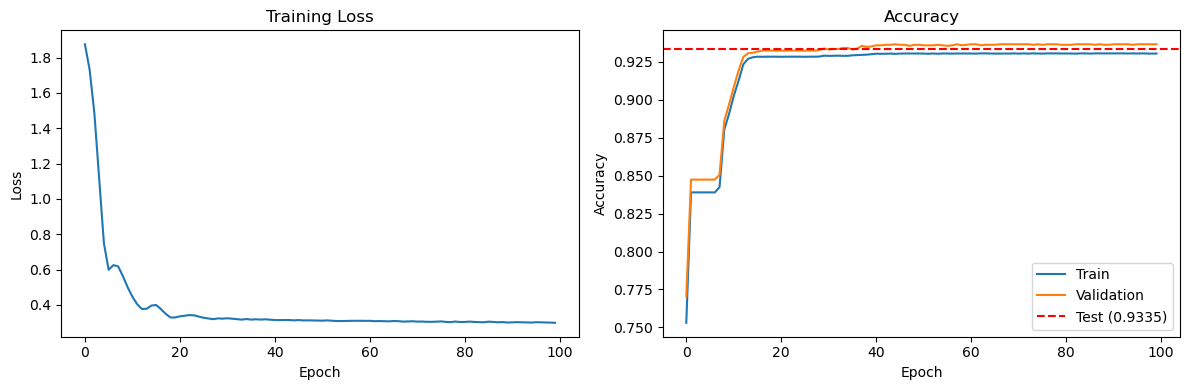


Success! Model trained with test accuracy: 0.9334726576105886
Error during pipeline execution: 'GlobalStorage' object has no attribute 'num_classes'


Traceback (most recent call last):
  File "/tmp/ipykernel_453678/1666859710.py", line 337, in run_gnn_pipeline
    predictions, class_report = evaluate_by_class(model, data)
  File "/tmp/ipykernel_453678/3259641526.py", line 228, in evaluate_by_class
    class_names = [f"Monument Type {i}" for i in range(data.num_classes)]
  File "/home/user/anaconda3/envs/pytorch_base/lib/python3.10/site-packages/torch_geometric/data/data.py", line 561, in __getattr__
    return getattr(self._store, key)
  File "/home/user/anaconda3/envs/pytorch_base/lib/python3.10/site-packages/torch_geometric/data/storage.py", line 96, in __getattr__
    raise AttributeError(
AttributeError: 'GlobalStorage' object has no attribute 'num_classes'


In [21]:
# Assuming you have your subset_kg object from previous steps
# If you had issues with the subset creation, here's a quick fix:

# 1. Create the subset one more time
subset_percentage = 0.02
min_per_type = 10
subset_triples = create_fair_kg_subset(data, sample_percentage=subset_percentage, min_entities_per_type=min_per_type)

# 2. Create a simple wrapper around the subset data
class SimpleSubsetKG:
    def __init__(self, original_data, subset_triples):
        self.i2r = original_data.i2r
        self.i2e = original_data.i2e
        self.triples = subset_triples if subset_triples is not None else np.array([])

# 3. Create the subset object
subset_kg = SimpleSubsetKG(data, subset_triples)

# 4. Run the GNN pipeline on the subset
model, graph_data, entity_to_idx, relation_to_idx = run_gnn_pipeline(subset_kg)

In [22]:
from typing import Tuple, Union

import torch
import torch_sparse
from torch_geometric.nn.inits import glorot, uniform
from torch_sparse import SparseTensor


def calc_ppv(
    x: torch.Tensor, adj_t: Union[torch.Tensor, torch_sparse.SparseTensor]
) -> torch.Tensor:
    """Calculates 1-hop proportion of positive values per representation dimension

    Args:
        x (torch.Tensor):
            Input node representations.

        adj_t (torch.Tensor or torch_sparse.SparseTensor):
            Adjacency matrix. Either in 2-row head/tail format or using a SparseTensor.

    Returns:
        torch.Tensor: Proportion of positive values features.
    """
    if isinstance(adj_t, torch.Tensor):
        adj_t = SparseTensor(row=adj_t[0], col=adj_t[1]).to(x.device).t()
    adj_t = adj_t.set_value(None, layout=None)
    return torch_sparse.matmul(adj_t, (x > 0).float(), reduce="mean")


def glorot_seed(
    shape: Tuple,
    device: Union[torch.device, str] = "cuda",
    seed: int = 42,
    dtype: torch.dtype = torch.float32,
) -> torch.Tensor:
    """Randomly generates a tensor based on a seed and Glorot initialization.

    Args:
        shape (Tuple):
            Desired shape of the tensor.

        device (torch.device or str, optional):
            Device to generate tensor on. Defaults to "cuda".

        seed (int, optional):
            The seed. Defaults to 42.

        dtype (torch.dtype, optional):
            Tensor type. Defaults to torch.float32.

    Returns:
        torch.Tensor: The randomly generated tensor
    """
    torch.manual_seed(seed)
    a = torch.zeros(shape, device=device, dtype=dtype)
    glorot(a)
    return a


def uniform_seed(
    shape: Tuple,
    device: Union[torch.device, str] = "cuda",
    seed: int = 42,
    dtype: torch.dtype = torch.float32,
) -> torch.Tensor:
    """Randomly generates a tensor based on a seed and uniform initialization.

    Args:
        shape (Tuple):
            Desired shape of the tensor.

        device (torch.device or str, optional):
            Device to generate tensor on. Defaults to "cuda".

        seed (int, optional):
            The seed. Defaults to 42.

        dtype (torch.dtype, optional):
            Tensor type. Defaults to torch.float32.

    Returns:
        torch.Tensor: The randomly generated tensor
    """
    torch.manual_seed(seed)
    a = torch.zeros(shape, device=device, dtype=dtype)
    torch.nn.init.uniform_(a, a=-1, b=1)
    return a


def fan_out_uniform_seed(
    shape: Tuple,
    device: Union[torch.device, str] = "cuda",
    seed: int = 42,
    dtype: torch.dtype = torch.float32,
) -> torch.Tensor:
    """Randomly generates a tensor based on a seed and uniform initialization
    between -1/fan_out and 1/fan_out.

    Args:
        shape (Tuple):
            Desired shape of the tensor.

        device (torch.device or str, optional):
            Device to generate tensor on. Defaults to "cuda".

        seed (int, optional):
            The seed. Defaults to 42.

        dtype (torch.dtype, optional):
            Tensor type. Defaults to torch.float32.

    Returns:
        torch.Tensor: The randomly generated tensor
    """
    torch.manual_seed(seed)
    a = torch.zeros(shape, device=device, dtype=dtype)
    torch.nn.init.uniform_(a, a=-1 / shape[1], b=1 / shape[1])
    return a


def fan_out_normal_seed(
    shape: Tuple,
    device: Union[torch.device, str] = "cuda",
    seed: int = 42,
    dtype: torch.dtype = torch.float32,
) -> torch.Tensor:
    """Randomly generates a tensor based on a seed and normal initialization
    with std 1/fan_out.

    Args:
        shape (Tuple):
            Desired shape of the tensor.

        device (torch.device or str, optional):
            Device to generate tensor on. Defaults to "cuda".

        seed (int, optional):
            The seed. Defaults to 42.

        dtype (torch.dtype, optional):
            Tensor type. Defaults to torch.float32.

    Returns:
        torch.Tensor: The randomly generated tensor
    """
    torch.manual_seed(seed)
    a = torch.zeros(shape, device=device, dtype=dtype)
    torch.nn.init.normal_(a, std=1 / (shape[1]))
    return a

OSError: /home/user/anaconda3/envs/pytorch_base/lib/python3.10/site-packages/torch_sparse/_spmm_cuda.so: undefined symbol: _ZN5torch8autograd12VariableInfoC1ERKN2at6TensorE

In [ ]:
from typing import Dict, Optional, Tuple, Union

import torch
from torch import nn


class NodeEncoder(nn.Module):
    def __init__(
        self,
        emb_size: int,
        num_nodes: int,
        seed: int = 42,
        device: Union[torch.device, str] = "cuda",
    ):
        """Random (untrained) node encoder for the initial node embeddings,
        supports initial feature vectors (i.e. literal values, e.g. floats or
        sentence/word embeddings).

        The encoder supports nodes of different types, that each have different
        associated feature vectors. Every different "featured" node type should
        have an associated integer identifier.

        Args:
            emb_size (int):
                Desired embedding width.

            num_nodes (int):
                Number of nodes in the KG.

            seed (torch.Tensor, optional):
                Seed used to generate random transformations (fully characterizes the
                embedder). Defaults to 42.

            device (Union[torch.device, str], optional):
                PyTorch device to calculate embeddings on. Defaults to "cuda".
        """
        super(NodeEncoder, self).__init__()
        self.emb_size = emb_size
        self.device = device
        self.seed = seed
        self.num_nodes = num_nodes

    def forward(
        self,
        node_features: Optional[Dict[int, Tuple[torch.Tensor, torch.Tensor]]] = None,
        node_idx: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        """Encodes nodes into an initial (random) representation, with nodes with
        intial features (e.g. numeric literals) taken into account.

        Args:
            node_features (Dict[int, Tuple[torch.Tensor, torch.Tensor]], optional):
                Dictionary with featured node type identifiers as keys, and tuples
                of node indices and initial features as values.

                For example, if nodes `[3, 5, 7]` are literals of type `5`
                with numeric values `[0.7, 0.1, 0.5]`, `node_features` should be:
                `{5: (torch.tensor([3, 5, 7]), torch.tensor([0.7], [0.1], [0.5]))}`

                Featured nodes are not limited to numeric literals, e.g. word embeddings
                can also be passed for string literals.

                The node indices used to specify the locations of literal nodes
                should be included in `node_idx` (if supplied).

                If None, all nodes are assumed to be feature-less. Defaults to None.

            node_idx (torch.Tensor, optional):
                Useful for batched embedding calculation. Mapping from node indices
                used in the given (sub)graph's adjancency matrix to node indices in the
                original graph. Defaults to None.


        Returns:
            torch.Tensor: Initial node representations
        """
        if node_idx is None:
            node_idx = torch.arange(self.num_nodes)

        # use fan_out_seed instead of glorot to make range independent of
        # the number of nodes
        node_embs = fan_out_normal_seed(
            (self.num_nodes, self.emb_size),
            seed=self.seed,
            device="cuda",
        )

        if node_features is not None:
            for type_id, (idx, feat) in node_features.items():
                assert (
                    idx.dtype == torch.long
                ), f"Node indices for {type_id} should be long"
                idx = idx.ravel()

                assert torch.isin(
                    idx.to(self.device), node_idx.to(self.device)
                ).all(), (
                    f"Featured node indices for {type_id} should all be"
                    + "in the current subgraph"
                )
                assert len(feat.shape) == 2, (
                    f"Node feature tensor for {type_id} should be two-dimensional"
                    + "First dimension number of nodes of this type, second dimension"
                    + "number of features."
                )
                assert feat.shape[0] == idx.numel(), (
                    f"Featured node index tensor for {type_id} should have"
                    + "as many elements as there are feature vectors"
                )

                # Use fan_out_seed instead of glorot to easily make the variance
                # of featured nodes equal to those of unfeatured nodes:
                #
                # var(feat @ random_transform) = var(feat) * var(random_transform)
                #                                * num_features
                #                               (var of prod of indep 0-mean distr +
                #                                var of sum of indep distr,
                #                                because of matmul)
                #
                # we want to scale feat such that
                #   var(feat_scaled @ random_transform) == var(node_features)
                # so: var(feat_scaled) =
                #               var(node_features) /
                #               (var(random_tranfsorm) * num_features)
                #
                # we set var(random_transform) equal to var(node_features), thus
                # var(feat_scaled) should be 1/num_features
                random_transform = fan_out_normal_seed(
                    (feat.shape[1], self.emb_size),
                    seed=self.seed + type_id,
                    device=self.device,
                )

                # Here, features are assumed to be normalized. Before matmul with
                # random transform, divide by sqrt(fan_in) to make sure resulting embs
                # have the same variance as non-featured nodes
                node_embs[idx.to(self.device), :] = (
                    (feat.to(self.device) / (float(feat.shape[1]) ** (1 / 2)))
                    @ random_transform
                ).to(self.device)

        # Generate initital node embeddings on CPU and only transfer
        # necessary nodes to GPU once masked
        return node_embs[node_idx.to(self.device), :].to(self.device)

In [ ]:
# Based on PyG's RGCNConv implementation
# https://github.com/pyg-team/pytorch_geometric/blob/master/torch_geometric/nn/conv/rgcn_conv.py
from typing import Tuple, Union

import numpy as np
import torch
from torch import Tensor
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.conv.rgcn_conv import masked_edge_index
from torch_geometric.typing import Adj, OptTensor
from torch_sparse import SparseTensor, matmul


class RandomRGCNConv(MessagePassing):
    def __init__(
        self,
        in_channels: Union[int, Tuple[int, int]],
        out_channels: int,
        num_relations: int,
        seed: int = None,
        **kwargs,
    ):
        r"""Random graph convolution operation, characterized by a single seed.

        Args:
            in_channels (int or tuple):
                Size of each input sample. A tuple
                corresponds to the sizes of source and target dimensionalities.
                In case no input features are given, this argument should
                correspond to the number of nodes in your graph.

            out_channels (int):
                Size of each output sample.

            num_relations (int):
                Number of relations.

            seed (int):
                Random seed (fully characterizes the layer).

            **kwargs (optional):
                Additional arguments of
                :class:`torch_geometric.nn.conv.MessagePassing`.
        """
        super().__init__(aggr="mean", node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_relations = num_relations

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)

        self.in_channels_l = in_channels[0]
        self.in_channels_r = in_channels[0]

        if seed is None:
            self.seed = np.random.randint(1000000)
        else:
            self.seed = seed

        rng = np.random.default_rng(self.seed)
        self.seeds = rng.integers(1e6, size=num_relations + 1)
        self.root = self.seeds[-1]

    def forward(
        self,
        x: Union[OptTensor, Tuple[OptTensor, Tensor]],
        edge_index: Adj,
        edge_type: OptTensor = None,
    ):
        r"""
        Args:
            x:
                The input node features. Can be either a :obj:`[num_nodes,
                in_channels]` node feature matrix, or an optional
                one-dimensional node index tensor (in which case input features
                are treated as trainable node embeddings).
                Furthermore, :obj:`x` can be of type :obj:`tuple` denoting
                source and destination node features.

            edge_index (LongTensor or SparseTensor):
                The edge indices.

            edge_type:
                The one-dimensional relation type/index for each edge in
                :obj:`edge_index`.
                Should be only :obj:`None` in case :obj:`edge_index` is of type
                :class:`torch_sparse.tensor.SparseTensor`.
                (default: :obj:`None`)
        """
        x_l: OptTensor = None
        x_l = x

        x_r: Tensor = x_l
        if isinstance(x, tuple):
            x_r = x[1]

        size = (x_l.size(0), x_r.size(0))

        if isinstance(edge_index, SparseTensor):
            edge_type = edge_index.storage.value()
        assert edge_type is not None

        out = torch.zeros(x_r.size(0), self.out_channels, device=x_r.device)
        for i in range(self.num_relations):
            weight = glorot_seed(
                (self.in_channels_l, self.out_channels),
                seed=self.seeds[i],
                device=x_r.device,
            )

            tmp = masked_edge_index(edge_index, edge_type == i)

            if x_l.dtype == torch.long:
                out += self.propagate(tmp, x=weight[x_l], size=size)
            else:
                out += self.propagate(tmp, x=(x_l @ weight), size=size)
            del weight

        if self.root is not None:
            root = glorot_seed(
                (self.in_channels_l, self.out_channels),
                seed=self.root,
                device=x_r.device,
            )
            out += root[x_r] if x_r.dtype == torch.long else x_r @ root

        return out

    def message(self, x_j: Tensor) -> Tensor:
        return x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        adj_t = adj_t.set_value(None, layout=None)
        h = x
        return matmul(adj_t, h, reduce=self.aggr)

    def __repr__(self) -> str:
        return (
            f"{self.__class__.__name__}({self.in_channels}, "
            f"{self.out_channels}, num_relations={self.num_relations})"
        )

In [ ]:
from copy import deepcopy
from typing import Dict, Optional, Tuple, Union

import pandas as pd
import sklearn
import sklearn.base
import sklearn.preprocessing
import torch
import torch.nn.functional as F
import torch_sparse
from torch_geometric.utils import k_hop_subgraph
from torch_sparse import SparseTensor
from tqdm import tqdm


class RRGCNEmbedder(torch.nn.Module):
    def __init__(
        self,
        num_nodes: int,
        num_layers: int,
        num_relations: int,
        emb_size: int,
        device: Union[torch.device, str] = "cuda",
        ppv: bool = True,
        seed: int = 42,
        min_node_degree: int = 0,
    ):
        """Random Relational Graph Convolutional Network Knowledge Graph Embedder.

        Args:
            num_nodes (int):
                Number of nodes in the KG.

            num_layers (int):
                Number of random graph convolutions.

            num_relations (int):
                Number of relations in the KG.

            emb_size (int):
                Desired embedding width.

            device (torch.device or str, optional):
                PyTorch device to calculate embeddings on. Defaults to "cuda".

            ppv (bool, optional):
                If True, concatenate PPV features to embeddings (this effectively
                doubles the embedding width). Defaults to True.

            seed (int, optional):
                Seed used to generate random transformations (fully characterizes the
                embedder). Defaults to 42.

            min_node_degree (int, optional):
                If set, embedder first remove all nodes with a degree lower
                than the given argument from the graph before taking subgraph.
                Defaults to 0.
        """
        super().__init__()
        self.device = device
        self.ppv = ppv
        self.num_nodes = num_nodes
        self.emb_size = emb_size
        self.seed = seed
        self.num_layers = num_layers
        self.min_node_degree = min_node_degree

        self.layers = [
            RandomRGCNConv(emb_size, emb_size, num_relations, seed=seed)
            for _ in range(num_layers)
        ]

        self.ne = NodeEncoder(
            emb_size=emb_size, num_nodes=num_nodes, seed=self.seed, device=device
        )

    def forward(
        self,
        edge_index: Union[torch.Tensor, torch_sparse.SparseTensor],
        edge_type: Optional[torch.Tensor] = None,
        node_features: Optional[Dict[int, Tuple[torch.Tensor, torch.Tensor]]] = None,
        node_idx: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        """Calculates node embeddings for a (sub)graph specified by
        a typed adjacency matrix

        Args:
            edge_index (torch.Tensor or torch_sparse.SparseTensor):
                Adjacency matrix. Either in 2-row head/tail format or using
                a SparseTensor.

            edge_type (torch.Tensor, optional):
                Types for each edge in `edge_index`. Can be omitted if `edge_index` is
                a SparseTensor where types are included as values. Defaults to None.

            node_features (Dict[int, Tuple[torch.Tensor, torch.Tensor]], optional):
                Dictionary with featured node type identifiers as keys, and tuples
                of node indices and initial features as values.

                For example, if nodes `[3, 5, 7]` are literals of type `5`
                with numeric values `[0.7, 0.1, 0.5]`, `node_features` should be:
                `{5: (torch.tensor([3, 5, 7]), torch.tensor([0.7], [0.1], [0.5]))}`

                Featured nodes are not limited to numeric literals, e.g. word embeddings
                can also be passed for string literals.

                The node indices used to specify the locations of literal nodes
                should be included in `node_idx` (if supplied).

            node_idx (torch.Tensor, optional):
                Useful for batched embedding calculation. Mapping from node indices
                used in the given (sub)graph's adjancency matrix to node indices in the
                original graph. Defaults to None.

        Returns:
            torch.Tensor: Node embeddings for given (sub)graph.
        """
        if node_idx is None:
            node_idx = torch.arange(edge_index.max() + 1)

        # Use kwargs to support both torch_sparse adjacency tensors
        # and edge_index, edge_type
        kwargs = {"edge_index": edge_index}
        if edge_type is not None:
            kwargs = {**kwargs, "edge_type": edge_type}

        x = self.ne(node_features, node_idx)

        x = self.layers[0](x, **kwargs)

        if self.ppv:
            # Calculate proportion of positive values in 1-hop neighbourhood
            # after first convolution
            ppv = calc_ppv(x, edge_index)

            # Free GPU memory for next conv layer
            ppv = ppv.to(self.device)

        for conv in self.layers[1:]:
            x = F.relu(x)
            x = conv(x, **kwargs)

            if self.ppv:
                # Free GPU memory for PPV calculation
                x = x.to(self.device)

                # Return PPV to GPU
                ppv = ppv.to(self.device)

                # Random message passing with previous PPV as features
                ppv = conv(ppv, **kwargs)

                # Calculate new PPV
                ppv = calc_ppv(ppv, edge_index)

                # Free GPU memory for next conv layer
                ppv = ppv.to(self.device)

                # Return conv activations to GPU
                x = x.to(self.device)

        if self.ppv:
            # Return conv activations to GPU
            x = x.to(self.device)

            # Concatenate final conv activations and PPV features
            x = torch.hstack((x, ppv))

        return x

    def get_last_fit_scalers(self) -> Dict[int, sklearn.base.TransformerMixin]:
        """If during the last call to `embeddings()`, scalers were fit,
        returns the per featured node fitted sklearn scalers.

        Returns:
            Dict[int, sklearn.base.TransformerMixin]: the fitted scalers
        """
        return self.node_features_scalers

    def estimated_peak_memory_usage(
        self,
        edge_index: Union[torch.Tensor, torch_sparse.SparseTensor],
        batch_size: int = 0,
        idx: Optional[torch.Tensor] = None,
        subgraph: bool = True,
        **kwargs
    ):
        """Calculates the theoretical peak memory usage for a set of arguments
        given to `RRGCNEmbedder.embeddings()`

        Args:
            edge_index (torch.Tensor or torch_sparse.SparseTensor):
                Adjacency matrix. Either in 2-row head/tail format or using a
                SparseTensor.

            edge_type (torch.Tensor, optional):
                Types for each edge in `edge_index`. Can be omitted if `edge_index` is a
                SparseTensor where types are included as values. Defaults to None.

            batch_size (int, optional):
                Number of nodes in a single batch. For every batch, a subgraph with
                number of hops equal to the number of graph convolutions around the
                included nodes is extracted and used for message passing. If
                `batch_size` is 0, all nodes of interest are contained in a
                single batch. Defaults to 0.

            idx (torch.Tensor, optional):
                Node indices to extract embeddings for (e.g. indices for
                train- and test entities). If None, extracts embeddings for all nodes
                in the graph. Defaults to None.

            subgraph (bool, optional):
                If False, the function does not take a k-hop subgraph before executing
                message passing. This is useful for small graphs where embeddings can be
                extracted full-batch and calculating the subgraph comes with a
                significant overhead. Defaults to True.

        Returns:
            int: Theoretical peak memory usage in number of bytes
        """
        if subgraph:
            if idx is None:
                # Generate embeddings for all nodes
                all_nodes = torch.arange(edge_index.max() + 1)
            else:
                # Only generate embeddings for subset of nodes
                # (e.g. labelled train + test nodes)
                all_nodes = idx

            if batch_size < 1:
                # Full-batch
                batches = [all_nodes]
            else:
                # Split nodes to generate embeddings for into batches
                batches = all_nodes.split(batch_size)

            num_nodes_per_batch = []
            for batch in batches:
                # Calculate batch subgraph with smaller number of nodes and edges
                nodes, _, _, _ = k_hop_subgraph(
                    batch, self.num_layers, edge_index, relabel_nodes=True
                )
                num_nodes_per_batch.append(len(nodes))

            max_num_nodes = max(num_nodes_per_batch)
        else:
            max_num_nodes = edge_index.max() + 1

        factor = 4  # 4 if self.ppv else 3
        return factor * max_num_nodes * self.emb_size * 4  # in number of bytes

    @torch.no_grad()
    def embeddings(
        self,
        edge_index: Union[torch.Tensor, torch_sparse.SparseTensor],
        edge_type: Optional[torch.Tensor] = None,
        batch_size: int = 0,
        node_features: Optional[Dict[int, Tuple[torch.Tensor, torch.Tensor]]] = None,
        node_features_scalers: Optional[
            Union[Dict[int, sklearn.base.TransformerMixin], str]
        ] = "standard",
        idx: Optional[torch.Tensor] = None,
        subgraph: bool = True,
    ) -> torch.Tensor:
        """Generate embeddings for a given set of nodes of interest.

        Args:
            edge_index (torch.Tensor or torch_sparse.SparseTensor):
                Adjacency matrix. Either in 2-row head/tail format or using a
                SparseTensor.

            edge_type (torch.Tensor, optional):
                Types for each edge in `edge_index`. Can be omitted if `edge_index` is a
                SparseTensor where types are included as values. Defaults to None.

            batch_size (int, optional):
                Number of nodes in a single batch. For every batch, a subgraph with
                number of hops equal to the number of graph convolutions around the
                included nodes is extracted and used for message passing. If
                `batch_size` is 0, all nodes of interest are contained in a
                single batch. Defaults to 0.

            node_features (Dict[int, Tuple[torch.Tensor, torch.Tensor]], optional):
                Dictionary with featured node type identifiers as keys, and tuples
                of node indices and initial features as values.

                For example, if nodes `[3, 5, 7]` are literals of type `5`
                with numeric values `[0.7, 0.1, 0.5]`, `node_features` should be:
                `{5: (torch.tensor([3, 5, 7]), torch.tensor([0.7], [0.1], [0.5]))}`

                Featured nodes are not limited to numeric literals, e.g. word embeddings
                can also be passed for string literals.

                The node indices used to specify the locations of literal nodes
                should be included in `idx` (if supplied).

           node_features_scalers (Dict[int, TransformerMixin] or str, optional):
                Dictionary with featured node type identifiers as keys, and sklearn
                scalers as values. If scalers are not fit, they will be fit on the data.
                The fit scalers can be retrieved using `.get_last_fit_scalers()`.
                Can also be "standard", "robust", "power", "quantile" as shorthands for
                an unfitted StandardScaler, RobustScaler, PowerTransformer and
                QuantileTransformer respectively.
                If None, no scaling is applied. Defaults to "standard".

            idx (torch.Tensor, optional):
                Node indices to extract embeddings for (e.g. indices for
                train- and test entities). If None, extracts embeddings for all nodes
                in the graph. Defaults to None.

            subgraph (bool, optional):
                If False, the function does not take a k-hop subgraph before executing
                message passing. This is useful for small graphs where embeddings can be
                extracted full-batch and calculating the subgraph comes with a
                significant overhead. Defaults to True.

        Returns:
            torch.Tensor: Node embeddings for given nodes of interest
        """
        self.eval()

        if idx is None:
            # Generate embeddings for all nodes
            all_nodes = torch.arange(edge_index.max() + 1)
        else:
            # Only generate embeddings for subset of nodes
            # (e.g. labelled train + test nodes)
            all_nodes = idx

        if batch_size < 1:
            # Full-batch
            batches = [all_nodes]
        else:
            # Split nodes to generate embeddings for into batches
            batches = all_nodes.split(batch_size)

        normalized_node_features = node_features
        if node_features is not None and node_features_scalers is not None:
            normalized_node_features = deepcopy(node_features)

            if isinstance(node_features_scalers, str):
                assert node_features_scalers in [
                    "standard",
                    "robust",
                    "power",
                    "quantile",
                ]

                kwargs = {}
                if node_features_scalers == "standard":
                    scaler = sklearn.preprocessing.StandardScaler
                elif node_features_scalers == "robust":
                    scaler = sklearn.preprocessing.RobustScaler
                elif node_features_scalers == "power":
                    scaler = sklearn.preprocessing.PowerTransformer
                elif node_features_scalers == "quantile":
                    scaler = sklearn.preprocessing.QuantileTransformer
                    kwargs = {**kwargs, "output_distribution": "normal"}

                self.node_features_scalers = {
                    k: scaler(**kwargs) for k, _ in node_features.items()
                }
            else:
                self.node_features_scalers = deepcopy(node_features_scalers)

            for type_id, (typed_idx, feat) in node_features.items():
                if (
                    type_id not in self.node_features_scalers
                    or self.node_features_scalers[type_id] is None
                ):
                    continue

                if not hasattr(self.node_features_scalers[type_id], "n_features_in_"):
                    self.node_features_scalers[type_id] = self.node_features_scalers[
                        type_id
                    ].fit(feat)

                normalized_node_features[type_id] = (
                    typed_idx,
                    torch.tensor(
                        self.node_features_scalers[type_id].transform(feat),
                        device=self.device,
                        dtype=torch.float32,
                    ),
                )

        embs = []
        for batch in tqdm(batches):
            if self.min_node_degree > 0:
                degrees = pd.Series(edge_index[0].to(self.device).numpy()).value_counts()
                low_degree = set(
                    degrees[degrees < self.min_node_degree].index.to_numpy()
                )
                low_degree = torch.tensor(
                    list(low_degree.difference(set(all_nodes.cpu().numpy())))
                ).to(edge_index.device)

                degree_mask = ~(
                    torch.isin(edge_index[0], low_degree)
                    | torch.isin(edge_index[1], low_degree)
                ).to(edge_index.device)
                deg_edge_index = edge_index[:, degree_mask]
                deg_edge_type = edge_type[degree_mask]
            else:
                deg_edge_index = edge_index
                deg_edge_type = edge_type

            if subgraph:
                # Calculate batch subgraph with smaller number of nodes and edges
                nodes, sub_edge_index, mapping, edge_preserved = k_hop_subgraph(
                    batch, self.num_layers, deg_edge_index, relabel_nodes=True
                )
                sub_edge_type = deg_edge_type[edge_preserved]
            else:
                nodes, sub_edge_index, mapping, sub_edge_type = (
                    torch.arange(edge_index.max() + 1),
                    deg_edge_index,
                    batch,
                    deg_edge_type,
                )

            adj_t = (
                SparseTensor(
                    row=sub_edge_index[0],
                    col=sub_edge_index[1],
                    value=sub_edge_type,
                )
                .to(self.device)
                .t()
            )

            sub_node_features = None
            if node_features is not None:
                sub_node_features = {}
                for type_id, (typed_idx, feat) in normalized_node_features.items():
                    mask = torch.isin(typed_idx.to(nodes.device), nodes)
                    selected_idx = typed_idx[mask]
                    if selected_idx.numel() == 0:
                        continue

                    sub_node_features[type_id] = (selected_idx, feat[mask])

            # Calculate embeddings for all nodes participating in batch and then select
            # the queried nodes
            emb = (
                self(adj_t, node_idx=nodes, node_features=sub_node_features)[mapping]
                .detach()
                .to(self.device)
            )
            embs.append(emb)

        return torch.concat(embs)

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import ast
from sklearn.model_selection import train_test_split

# Assuming you have already loaded your data object

print("=" * 50)
print("Generating Graph Embeddings for Knowledge Graph")
print("=" * 50)

# Convert triples to edge index and edge type
# Create edge_index tensor in the format expected by PyTorch Geometric (2 x num_edges)
edge_index = torch.tensor(np.vstack([data.triples[:, 0], data.triples[:, 2]]), dtype=torch.long)
edge_type = torch.tensor(data.triples[:, 1], dtype=torch.long)

# Create train/validation splits if not already defined
if not hasattr(data, 'train_idx') or not hasattr(data, 'validation_idx'):
    # Get all entity indices
    all_indices = torch.arange(data.num_entities)
    
    # Create an 80/20 train/validation split
    train_idx, validation_idx = train_test_split(all_indices, test_size=0.2, random_state=42)
    
    # Convert to tensors
    train_idx = torch.tensor(train_idx, dtype=torch.long)
    validation_idx = torch.tensor(validation_idx, dtype=torch.long)
else:
    train_idx = data.train_idx
    validation_idx = data.validation_idx

print(f"Number of entities: {data.num_entities}")
print(f"Number of relations: {data.num_relations}")
print(f"Number of triples: {data.triples.shape[0]}")
print(f"Training set size: {len(train_idx)}")
print(f"Validation set size: {len(validation_idx)}")

# Initialize the embedder
embedder = RRGCNEmbedder(num_nodes=data.num_entities,
                         num_relations=data.num_relations, 
                         num_layers=2, 
                         emb_size=2048,
                         device="cuda",
                         ppv=True)

# Create a helper function to show progress
def print_progress(message):
    print(f"[Progress] {message}")

print_progress("Starting embedding generation")

# Generate embeddings
with torch.no_grad():
    embeddings = embedder.embeddings(edge_index, 
                               edge_type,
                               batch_size=512,  # full-batch processing
                               idx=torch.hstack((train_idx, validation_idx)))

print_progress("Embeddings generated successfully")

# Split embeddings into train and validation sets
train_embeddings = embeddings[:len(train_idx)]
validation_embeddings = embeddings[len(train_idx):]

print(f"Train embeddings shape: {train_embeddings.shape}")
print(f"Validation embeddings shape: {validation_embeddings.shape}")

# Creating an MLP classifier to use these embeddings
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class MLPClassifier(nn.Module):
    def __init__(self, input_size=2048, hidden_sizes=[1024, 512, 256], output_size=2, dropout_rate=0.2):
        super(MLPClassifier, self).__init__()
        
        # Create layers list
        layers = []
        
        # Input layer
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))
        
        # Hidden layers
        for i in range(len(hidden_sizes)-1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
        
        # Output layer
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        
        # Combine all layers into a sequential model
        self.classifier = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.classifier(x)

# If you have labels, prepare them for the classifier
# If you have multi-class labels, extract them from your data
# For example:
if hasattr(data, 'training'):
    # If labels are part of the 'training' attribute (assuming format [node_idx, label])
    train_labels = torch.tensor(data.training[:, 1], dtype=torch.long)
else:
    # Generate dummy labels for demonstration purposes
    # Replace this with actual labels from your dataset
    print("No labels found - using dummy labels for demonstration")
    num_classes = 2  # Change this to your actual number of classes
    train_labels = torch.randint(0, num_classes, (len(train_idx),))

# Instantiate the model
num_classes = len(torch.unique(train_labels))
print(f"Number of classes: {num_classes}")
model = MLPClassifier(input_size=2048, output_size=num_classes).to("cuda")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create dataset and dataloader
train_dataset = TensorDataset(train_embeddings, train_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Training loop
num_epochs = 5  # Reduced for demonstration
print("=" * 50)
print("Training MLP Classifier on Embeddings")
print("=" * 50)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}')

print("Training complete!")
print("=" * 50)

# Save your model and embeddings
torch.save(model.state_dict(), 'kg_classifier_model.pt')
torch.save({
    'train_embeddings': train_embeddings,
    'validation_embeddings': validation_embeddings,
    'train_idx': train_idx,
    'validation_idx': validation_idx
}, 'kg_embeddings.pt')

print("Model and embeddings saved to disk.")

/tmp/ipykernel_418818/1760299351.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_idx = torch.tensor(train_idx, dtype=torch.long)
/tmp/ipykernel_418818/1760299351.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_idx = torch.tensor(validation_idx, dtype=torch.long)


Generating Graph Embeddings for Knowledge Graph
Number of entities: 341270
Number of relations: 60
Number of triples: 777124
Training set size: 273016
Validation set size: 68254
[Progress] Starting embedding generation


  0%|          | 0/667 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.61 GiB. GPU 0 has a total capacity of 15.81 GiB of which 1.90 GiB is free. Process 417308 has 915.00 MiB memory in use. Including non-PyTorch memory, this process has 11.74 GiB memory in use. Of the allocated memory 10.49 GiB is allocated by PyTorch, and 34.92 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

: 